# Exercise Session 7 - Kernel SVM

## 1 Introduction

Welcome to the 7th exercise session of CS233 - Introduction to Machine Learning.  

We will continue using scikit-learn to train SVM with feature expansion and different kernel functions.

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from plots import plot, plot_expand, plot_expand_poly, plot_mykernel
from sklearn import svm
%load_ext autoreload
%autoreload 2

## 2 Non-Linear Classification
Recap from exercise 6, we have worked on linearly separable data in the given data space. Most of the time that's not the case. In this exercise, we will work on non-linearly separable data. Although the dataset is not linearly separable in the original data space, it can be linearly separable in the non-linear feature space which  is defined implicitly by the non-linear kernel functions. Thus the training data points are perfectly separated in the original data space.

### 2.1 Kernel SVM

Beyond the linear problem we discussed before, SVM can also solve non-linear classification problem by using kernel functions. We replace $\mathbf{x}_i$ with $\phi(\mathbf{x}_i)$, and then $\mathbf{x}_i^T\mathbf{x}_j$ with $k(\mathbf{x}_i,\mathbf{x}_j)$. The **dual form** of this problem is given by:  
\begin{align}
    \underset{\{\alpha_i\}}{\operatorname{max}} \ \ 
    & \sum_{i=1}^N \alpha_i - \frac 1 2 \sum_{i=1}^N\sum_{j=1}^N \alpha_i\alpha_jy_iy_jk(\mathbf{x}_i,\mathbf{x}_j)  \\   
    \operatorname{subject \ to} & \ \ \sum_{i=1}^N \alpha_iy_i = 0 \\
                 & \ \ 0 \leq \alpha_i \leq C, \forall i \ \ 
\end{align}
**Question**
   * How can you write $\tilde{\mathbf{w}}$ using $\alpha_i$ s and function $\phi$?
   * How is $y(\mathbf{x})$ represented using $\alpha_i$ s?
 
   
Have a look at the SVM function [here.](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) The main parameters you should look for are:
- Kernel Functions: Linear, Polynomial and RBF ($X$ is the data)
    - Linear: `linear`. $\langle X, X' \rangle $.
    - Polynomial: `poly`. $( \gamma \langle X, X' \rangle + r)^d $. $d$ is specified by keyword `degree`, $r$ by `coef0`.
    - RBF: `rbf`. $\exp(\gamma ||X - X'||^2)$. $\gamma$ is specified by keyword `gamma`, must be greater than 0.
- Penalty term: C 
- Gamma: for Polynomial and RBF kernel
- Degree: for Polynomial kernel


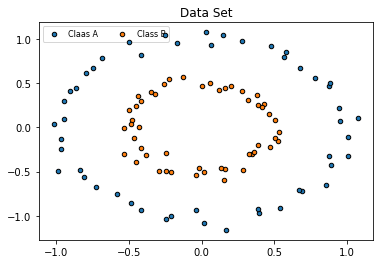

In [2]:
# Load data
from helpers import get_circle_dataset

X,Y = get_circle_dataset()
plot(X,Y,None,dataOnly=True)

The dataset is not linearly separable in the original two-dimensional data space.

### 2.2 Linear SVM on original dataset

**Question** Is a linear SVM able to separate the dataset? *of course not*

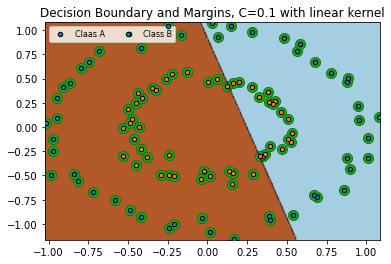

In [3]:
# Use SVM with linear kernel where C=0.1
# and you can also try some other Cs to see what will happen
clf_linear = svm.SVC(kernel='linear', C=0.1)
    
clf_linear.fit(X, Y)
plot(X, Y, clf_linear)

### 2.3 Polynomial SVM on the dataset from Polynomial Feature Expansion

As for Polynomial SVM, we first do polynomial feature expension to map the original data to a higher dimension. Then use a SVM with linear kernel to separate the expanded dataset.  

Fill in the function `expand_X()`. You should add a bias term, but **omit the interaction terms**. An example:

For $D=2$, $\text{degree_of_expansion}=2$ you have:
$$
\mathbf{x}_i = \begin{bmatrix}\mathbf{x}_i^{(0)}& \mathbf{x}_i^{(1)}\end{bmatrix}
$$
After the polynomial feature expansion, you would like to have:
$$ 
\mathbf{\phi}(\mathbf{x}_i) = \begin{bmatrix}\mathbf{1} & \mathbf{x}_i^{(0)} & \mathbf{x}_i^{(1)} & (\mathbf{x}_i^{(0)})^2 & (\mathbf{x}_i^{(1)})^2 \end{bmatrix}
$$

In [4]:
# Perform degree-d polynomial feature expansion of input data X
def expand_X(X, degree_of_expansion):
    """  Perform degree-d polynomial feature expansion of X, 
         with bias but omitting interaction terms
    
    Args:
        X (np.array): data, shape (N, D).
        degree_of_expansion (int): The degree of the polynomial feature expansion.
    
    Returns:
        expanded_X (np.array): Expanded data with shape (N, new_D), 
                               where new_D is D*degree_of_expansion+1
    
    """
    expanded_X = np.ones((X.shape[0],1))
    ### CODE HERE ###
    expanded_X = np.concatenate([expanded_X, X, X**degree_of_expansion], axis=1)    
        
    return expanded_X

The original data has 2 features.
After degree-2 polynomial feature expansion (with bias, without interaction terms) the data has 5 features.


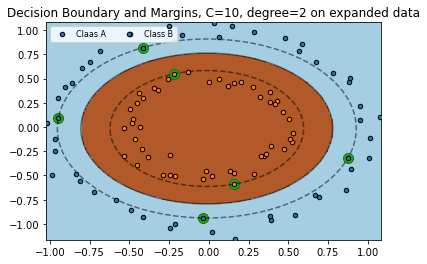

In [5]:
# Polynomial SVM
degree_of_expansion = 2

## Do polynomial feature expansion
### CODE HERE ###
expanded_X = expand_X(X,degree_of_expansion)

print("The original data has {} features.".format(X.shape[1]))
print("After degree-{} polynomial feature expansion (with bias, without interaction terms) the data has {} features.".format(degree_of_expansion,expanded_X.shape[1]))

## Use SVM with linear kernel on expanded data with C=10.0
### CODE HERE ###
expanded_clf = svm.SVC(kernel='linear', C=10)
expanded_clf.fit(expanded_X,Y)

plot_expand(X, Y, expanded_clf, degree_of_expansion)


Now, the non-linearly separable dataset can be separated by the Polynomial SVM.

### 2.4  SVM with Polynomial and RBF kernels

We then try out Polynomial and RBF kernels. 

Given data $\mathbf{X}$ with $N$ samples, its kernel matrix $\mathbf{K}$ is the $N \times N$ symmetric Gram matrix with elelments 

$$ \mathbf{K}_{n,m} = \phi(\mathbf{x}_n)^T\phi(\mathbf{x}_m) = k(\mathbf{x}_n, \mathbf{x}_m) $$

Have a look at kernel functions defined in scikit-learn:

- linear: $\langle \mathbf{X}, \mathbf{X'} \rangle $.
- poly: $( \gamma \langle \mathbf{X}, \mathbf{X'} \rangle + r)^d $. $d$ is specified by keyword `degree`, $r$ by `coef0`.
- rbf: $\exp(\gamma ||\mathbf{X} - \mathbf{X'}||^2)$. $\gamma$ is specified by keyword `gamma`, must be greater than 0.
where $X$ is the data.

Note that $\phi$ **does not appear explicitly** in these kernel functions.

Let's implement the polynomial kernel function.

In [6]:
# Preform your own polynomial kernel function
## Refer to the formula of poly kernel function above
def my_poly_kernel(X, Y, degree=3, gamma=1.0, coef0=1.0):
    """  Perform the degree-d polynomial kernel function on X and Y 
    Args:
        X (np.array): data, shape (N, D).
        Y (np.array): data, shape (N, D).
        degree (int): the degree of the polynomial kernel method.
    Returns:
        K (np.array): the kernel matrix from data matrices; that matrix should be an array of shape (N, N).    
    """
    ### CODE HERE ###
    K = (X @ Y.T + coef0 )**degree
    return K

**Question a**  What are the differences between polynomial feature expansion and polynomial kernel function? 

**Question b**  Is the SVM trained with linear kernel on polynomially expanded data same as the SVM trained with polynomial kernel function on original data?

We will check our implementation of polynomial kernel and to figure out the answer of Question b.

We will make use of [sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to do the polynomial feature expansion with **the interaction terms**.

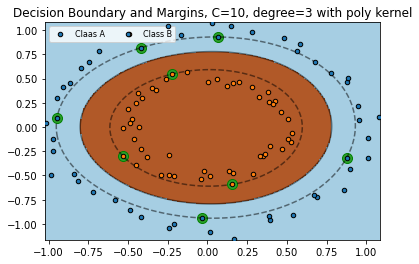

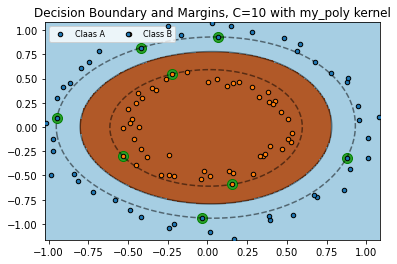

The original data has 2 features.
After degree-3 polynomial feature expansion (with bias, with interaction terms) the data has 10 features.


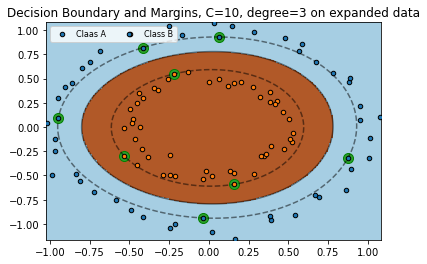

In [7]:
# These three SVM should be same.

degree_of_expansion = 3

# Baseline 
# Use SVM with poly kernel on original data with C=10.0, gamma=1.0, coef0=1.0
### CODE HERE ###
clf = svm.SVC(kernel='poly',C=10,gamma=1,coef0=1)
clf.fit(X,Y)

plot(X, Y, clf)

# Check my_poly_kernel
# Use SVM with my_poly_kernel on original adata with C=10.0
### CODE HERE ###
    # tip: kernel=my_poly_kernel
kernel_clf = svm.SVC(kernel=my_poly_kernel,C=10)
kernel_clf.fit(X,Y)

plot_mykernel(X, Y, kernel_clf)

# Answer Question b
# Use SVM with linear kernel on expanded data
## Use PolynomialFeatures to generate expanded data with the interaction terms
from sklearn.preprocessing import PolynomialFeatures
### CODE HERE ###
poly = PolynomialFeatures(degree=degree_of_expansion)
poly_expanded_X = poly.fit_transform(X)

print("The original data has {} features.".format(X.shape[1]))
print("After degree-{} polynomial feature expansion (with bias, with interaction terms) the data has {} features.".format(degree_of_expansion,poly_expanded_X.shape[1]))

## Use SVM with linear kernel on expanded data with C=10.0
### CODE HERE ###
poly_expanded_clf = svm.SVC(kernel='linear',C=10)
poly_expanded_clf.fit(poly_expanded_X,Y)

plot_expand_poly(X, Y, poly_expanded_clf, degree_of_expansion)


Let's play with different settings for different kernel functions (poly and rbf).

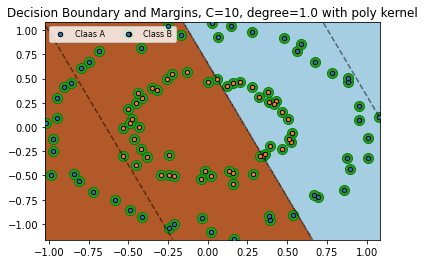

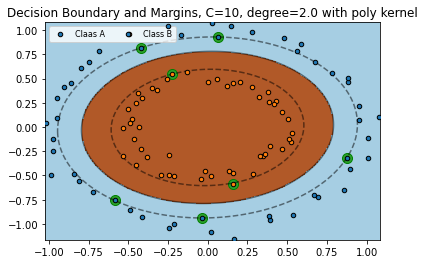

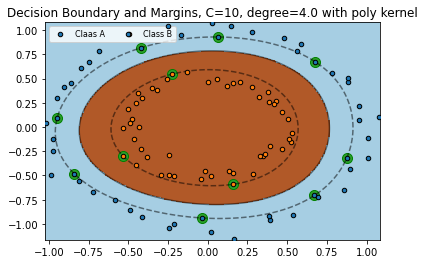

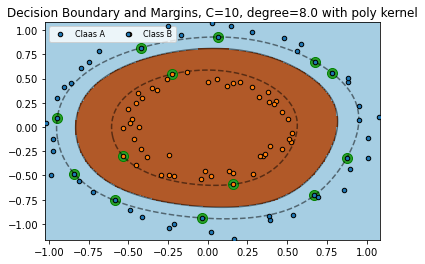

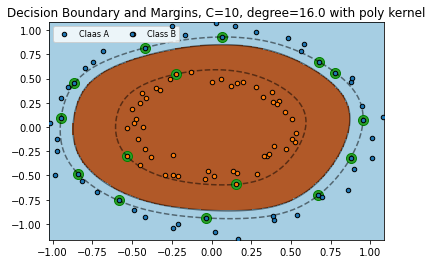

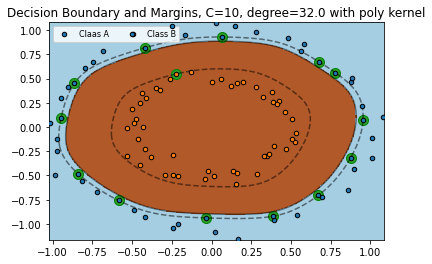

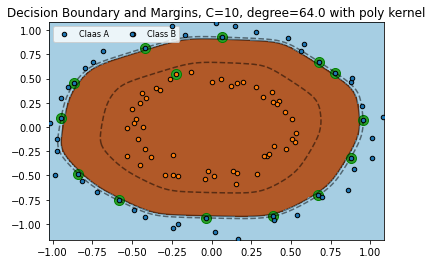

In [8]:
# Use SVM with polynomial kernel of different degrees
D = 2 ** np.linspace(0, 6, num=7)
for d in D:
    ## use poly kernel with C=10., gamma=1.0, coef0=1.0 and different degrees
    ### CODE HERE ###
    clf = svm.SVC(kernel='poly',C=10,degree=d,gamma=1,coef0=1)
    
    clf.fit(X, Y)
    plot(X, Y, clf)


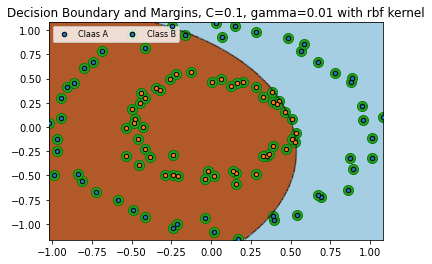

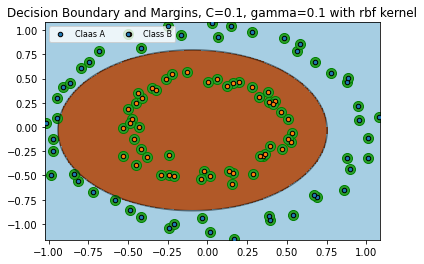

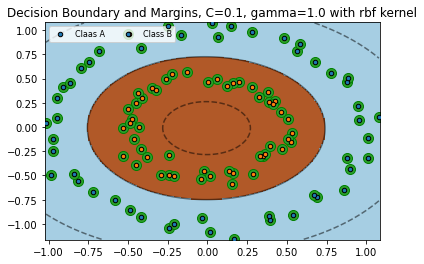

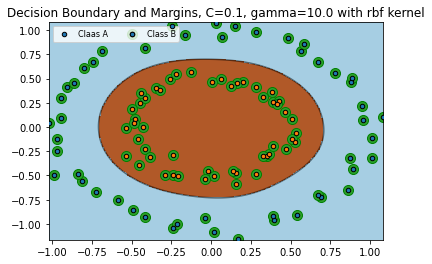

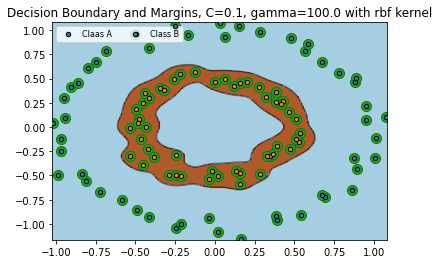

In [9]:
# Use SVM with RBF kernel with differen gammas
G = np.logspace(-2,2,num=5)
for g in G:
    ## use rbf kernel with C=0.1 and different gammas
    ### CODE HERE ###
    clf = svm.SVC(kernel='rbf',gamma=g,C=0.1)
    
    clf.fit(X, Y)
    plot(X, Y, clf)

**!!!** It is important to choose the approperiate parameters in the function.

**Question** Look at the given dataset again, which will be the best non-linear kernel in your mind? If you choose polynomial kernel, which degree will be the best? If you choose RBF kernel, which gamma will be the best?
- Polynomial: degree 2 and 3
- Gaussian: gamma 1.0

Here is the K-Fold cross validation for RBF kernel.

In [17]:
# K-Fold cross validation for searching parameters of RBF kernel.
from helpers import do_cross_validation, fold_indices

# seach in log space
grid_search_c = np.logspace(-4, 10, num=15)
grid_search_gamma = np.logspace(-9, 5, num=15)

#save the accuracies for the combination of hyperparameters
grid_val = np.zeros((len(grid_search_c), len(grid_search_gamma)))

# Do 4 fold cross validation
k_fold = 4
k_fold_ind = fold_indices(X.shape[0], k_fold)

for i, c in enumerate(grid_search_c):
    for j, g in enumerate(grid_search_gamma):
        print('Evaluating for C:{} gamma:{} ...'.format(c, g))
        
        ## call SVM with c,g as params.
        ### CODE HERE ####
        clf = svm.SVC(kernel='rbf',C=c,gamma=g)
        
        acc = np.zeros(k_fold)
        ## do cross validation
        for k in range(k_fold):
            acc[k] = do_cross_validation(clf, k, k_fold_ind, X, Y)
            
        ## fill out the grid_val by computing the mean accuracy from k_fold runs.
        ### CODE HERE ####
        grid_val[i,j] = np.mean(acc)


Evaluating for C:0.0001 gamma:1e-09 ...
Evaluating for C:0.0001 gamma:1e-08 ...
Evaluating for C:0.0001 gamma:1e-07 ...
Evaluating for C:0.0001 gamma:1e-06 ...
Evaluating for C:0.0001 gamma:1e-05 ...
Evaluating for C:0.0001 gamma:0.0001 ...
Evaluating for C:0.0001 gamma:0.001 ...
Evaluating for C:0.0001 gamma:0.01 ...
Evaluating for C:0.0001 gamma:0.1 ...
Evaluating for C:0.0001 gamma:1.0 ...
Evaluating for C:0.0001 gamma:10.0 ...
Evaluating for C:0.0001 gamma:100.0 ...
Evaluating for C:0.0001 gamma:1000.0 ...
Evaluating for C:0.0001 gamma:10000.0 ...
Evaluating for C:0.0001 gamma:100000.0 ...
Evaluating for C:0.001 gamma:1e-09 ...
Evaluating for C:0.001 gamma:1e-08 ...
Evaluating for C:0.001 gamma:1e-07 ...
Evaluating for C:0.001 gamma:1e-06 ...
Evaluating for C:0.001 gamma:1e-05 ...
Evaluating for C:0.001 gamma:0.0001 ...
Evaluating for C:0.001 gamma:0.001 ...
Evaluating for C:0.001 gamma:0.01 ...
Evaluating for C:0.001 gamma:0.1 ...
Evaluating for C:0.001 gamma:1.0 ...
Evaluating fo

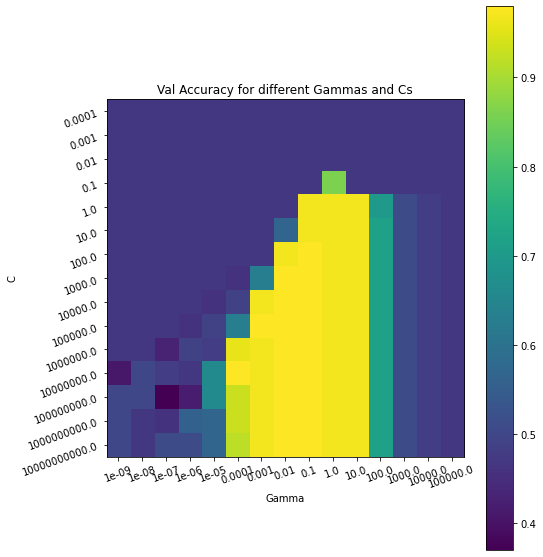

Best acc:0.98
Best Params- C:100.0, Gamma:0.1


In [18]:
from plots import plot_cv_result_rbf
## show all results and the best one
plot_cv_result_rbf(grid_val,grid_search_c,grid_search_gamma)
print('Best acc:{}'.format(np.max(grid_val)))
## best params
cin,gin = np.unravel_index(np.argmax(grid_val),grid_val.shape)
print('Best Params- C:{}, Gamma:{}'.format(grid_search_c[cin],grid_search_gamma[gin]))

Above heatmap shows accuracies for different Gamma and C values. The best params are used on test set.   
**Question** Is there a relation between C and Gamma?   
**Hint**: Think how increase in one value changes other. Look at the heatmap to get the idea. 

Then we do the K-Fold cross validation for polynominal kernel.

In [19]:
# K-Fold cross validation for searching parameters of Polynominal kernel.
from helpers import do_cross_validation, fold_indices

grid_search_c = np.logspace(-5,5,num=11)
grid_search_degree = 2 ** np.linspace(0, 8, num=9)

#save the accuracies for the combination of hyperparameters
grid_val = np.zeros((len(grid_search_c),len(grid_search_degree)))

# Do 4 fold cross validation
k_fold = 4
k_fold_ind = fold_indices(X.shape[0],k_fold)

for i, c in enumerate(grid_search_c):
    for j, d in enumerate(grid_search_degree):
        print('Evaluating for C:{} degree:{} ...'.format(c, d))
        
        ## call SVM with c,d as params.
        ### CODE HERE ####
        clf = svm.SVC(kernel='poly',C=c,degree=d)
        
        acc = np.zeros(k_fold)
        # do cross validation
        for k in range(k_fold):
            acc[k] = do_cross_validation(clf,k,k_fold_ind,X,Y)
            
        ## fill out the grid_val by computing the mean accuracy from k_fold runs. 
        ### CODE HERE ####
        grid_val[i,j] = np.mean(acc)
        

Evaluating for C:1e-05 degree:1.0 ...
Evaluating for C:1e-05 degree:2.0 ...
Evaluating for C:1e-05 degree:4.0 ...
Evaluating for C:1e-05 degree:8.0 ...
Evaluating for C:1e-05 degree:16.0 ...
Evaluating for C:1e-05 degree:32.0 ...
Evaluating for C:1e-05 degree:64.0 ...
Evaluating for C:1e-05 degree:128.0 ...
Evaluating for C:1e-05 degree:256.0 ...
Evaluating for C:0.0001 degree:1.0 ...
Evaluating for C:0.0001 degree:2.0 ...
Evaluating for C:0.0001 degree:4.0 ...
Evaluating for C:0.0001 degree:8.0 ...
Evaluating for C:0.0001 degree:16.0 ...
Evaluating for C:0.0001 degree:32.0 ...
Evaluating for C:0.0001 degree:64.0 ...
Evaluating for C:0.0001 degree:128.0 ...
Evaluating for C:0.0001 degree:256.0 ...
Evaluating for C:0.001 degree:1.0 ...
Evaluating for C:0.001 degree:2.0 ...
Evaluating for C:0.001 degree:4.0 ...
Evaluating for C:0.001 degree:8.0 ...
Evaluating for C:0.001 degree:16.0 ...
Evaluating for C:0.001 degree:32.0 ...
Evaluating for C:0.001 degree:64.0 ...
Evaluating for C:0.001 d

<class 'numpy.ndarray'>


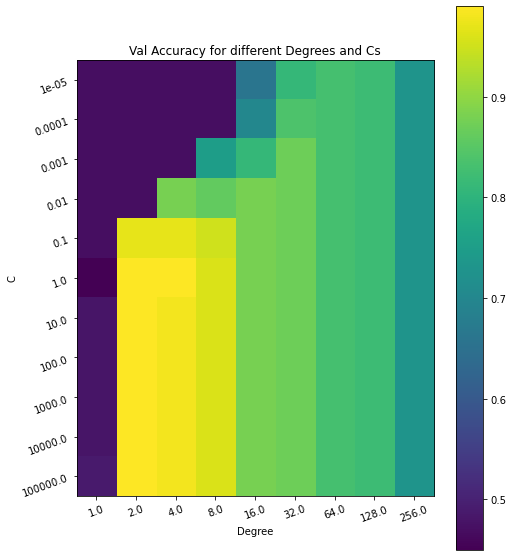

Best acc:0.99
Best Params- C:1.0, Degree:2.0


In [20]:
from plots import plot_cv_result_poly
## show all results and the best one
print(type(grid_val))
plot_cv_result_poly(grid_val, grid_search_c, grid_search_degree)
print('Best acc:{}'.format(np.max(grid_val)))
## best params
cin,gin = np.unravel_index(np.argmax(grid_val),grid_val.shape)
print('Best Params- C:{}, Degree:{}'.format(grid_search_c[cin],grid_search_degree[gin]))